In [1]:
import numpy as np
from matplotlib import pyplot as plt
import libs.MEVeS as S
import libs.AtomicConstants.Atom as A
import libs.Optimiser as Opt

In [39]:
pi_unicode = "\u03C0"
times_unicode = "\u00D7"

# First unlimited power!

### Test control initial condition 

In [11]:
### Make atom class
config = {"Hyperfine splitting": False, "states": {"initial": {"F": 4}, "intermediate": {"n": 6, "J": 3/2}, 
                                                    "storage": {"n": 6, "L":0, "F" : 3}}}
atom = A.Cs(config)

In [12]:
T = 273.15+80 # temperature of the ensemble in K
vno = 30 # number of velocity classes to simulate.
L = 0.075 # length of the cell in m

OD = atom.optical_depth(T, L)
print(f"OD (stationary) = {OD: .0f}")
ODeff = atom.effective_optical_depth(OD, T) # not needed for the simulation
print(f"Effective OD = {ODeff: .0f}")

n = 50 # number of space steps. Note these are not evenly spaced.

Sinits = np.zeros((n, len(atom.Fg), len(atom.mg), len(atom.Fq), len(atom.mq), vno)) # initial spin wave

OD (stationary) =  104004
Effective OD =  2299


In [14]:
### Make solver class
protocol = 'Raman'
tau = 1e-9
m = 800
detuning = 2*np.pi*2*atom.deltaHF

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 4*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

tr = 5e-9 # storage time

Omega_store = 3.4e10
Omega_retrieve = 9e10
Control_tp = (S.gaussian(t, t0, tau, Omega_store) + S.gaussian(t, t0+tr, tau, Omega_retrieve))[:, None] * control_pol[None, :] # control field

Control_tzp = sol.co_prop( Control_tp )
sol.solve(Control_tzp, method='RK4-Ralston')

storage = sol.storage_efficiency(sol.S, mi=m//2) # half way through simulation
retrieved = sol.retrieval_efficiency(sol.E, m//2, 0)

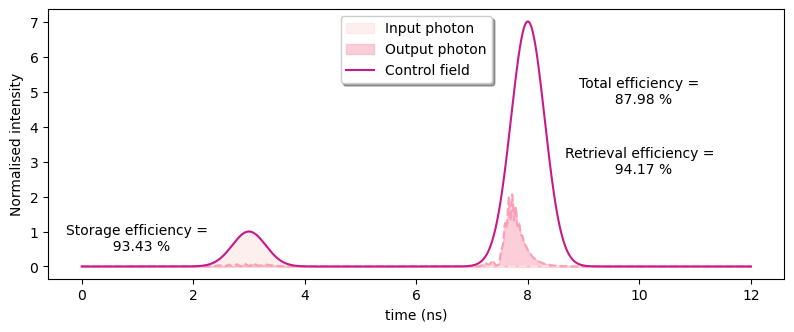

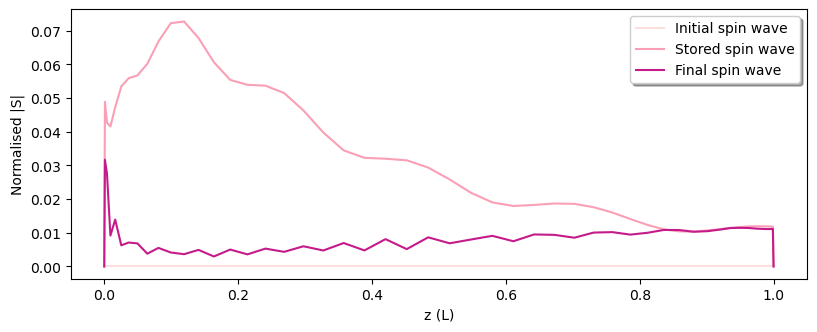

In [20]:
photon_norm = max(pow(np.abs(sol.E[:, 0, 0]),2)) # normalise factor for plotting photon field
control_norm = pow(np.abs(Omega_store), 2) # normalise factor for plotting control field

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(t*1e9, pow(np.abs(sol.E[:, 0, 0]),2)/photon_norm, color='#fde0ddff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, 0, 0])**2 /photon_norm, color='#fde0ddff', alpha=0.5, label='Input photon')
ax.plot(t*1e9, pow(np.abs(sol.E[:, -1, 0]),2)/photon_norm, color='#fa9fb5ff', linestyle='dashed')
ax.fill_between(t*1e9, np.abs(sol.E[:, -1, 0])**2 /photon_norm, color='#fa9fb5ff', alpha=0.5, label='Output photon')
ax.plot(t*1e9, np.abs(Control_tp[:, 0])**2/control_norm, color='#c51b8aff', label='Control field')
ax.set_ylabel('Normalised intensity', color='k')
ax.set_xlabel('time (ns)')
plt.legend(loc='upper center', fancybox=True, shadow=True)
plt.text(1, 0.8, f'Storage efficiency =\n {storage*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 5, f'Total efficiency =\n {retrieved*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.text(10, 3, f'Retrieval efficiency =\n {(retrieved/storage)*100: 0.2f} %', horizontalalignment='center', verticalalignment='center')
plt.show()

fig, ax = plt.subplots(figsize=(9.5, 3.5))

ax.plot(sol.zCheby, np.abs(sol.S[0, :, 0, 0, 0, 0, 0]), color='#fde0ddff', label='Initial spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[m//2, :, 0, 0, 0, 0, 0]), color='#fa9fb5ff', label='Stored spin wave')
ax.plot(sol.zCheby, np.abs(sol.S[-1, :, 0, 0, 0, 0, 0]), color='#c51b8aff', label='Final spin wave')
ax.set_ylabel('Normalised |S|', color='k')
ax.set_xlabel('z (L)')
plt.legend(loc='upper right', fancybox=True, shadow=True)
plt.show()

In [23]:
beam_radius = 100e-6

print(f"Storage control max power = {atom.rabi_frequency_to_power(Omega_store, r=beam_radius)*1000: .0f} mW")
print(f"Retrieval control max power = {atom.rabi_frequency_to_power(Omega_retrieve, r=beam_radius)*1000: .0f} mW")

Storage control max power =  2973 mW
Retrieval control max power =  20833 mW


### Optimise

In [21]:
### Make solver class
protocol = 'Raman'
tau = 1e-9
m = 800
detuning = 2*np.pi*2*atom.deltaHF

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 3.4e10)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, 9e10)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 100
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=104003.90754193695, total_eff=0.9785732957900315

Max amps: readin=36428083081.76806, readout=93037472027.19398

Total energy: readin=2.000357303132899e-08, readout=1.0500752389281284e-07



In [42]:
beam_radius = 100e-6

print(f"Optimised storage control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[0][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised storage control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[0][:, 0])), r=beam_radius)*1000: .0f} mW")

print(f"Optimised retrieval control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[1][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised retrieval control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[1][:, 0])), r=beam_radius)*1000: .0f} mW")

Optimised storage control max rabi frequency (2π × GHz) =  6 
Optimised storage control max power =  3413 mW
Optimised retrieval control max rabi frequency (2π × GHz) =  15 
Optimised retrieval control max power =  22263 mW


# Limit max power

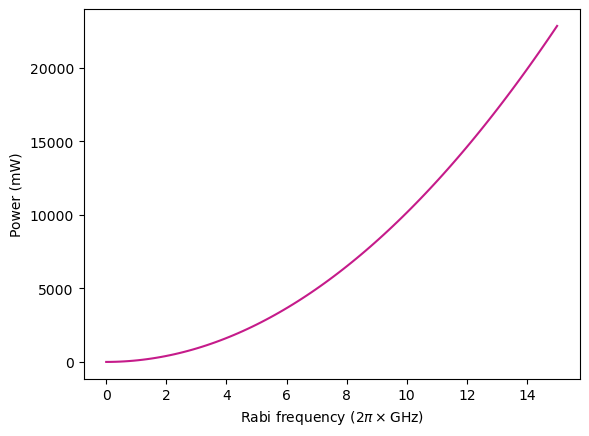

In [44]:
beam_radius = 100e-6 # in m
Omegas = np.linspace(0, 2*np.pi*1e9 * 15, 100) # list of rab frequencies

powers = atom.rabi_frequency_to_power(Omegas, r=beam_radius) # cw power

plt.plot(Omegas/(2*np.pi*1e9), powers*1e3, color='#c51b8aff')
plt.ylabel(u'Power (mW)')
plt.xlabel(r'Rabi frequency ($2\pi \times$GHz)')
plt.show()

### Optimise with 2 $\pi \times$ 10 GHz max rabi frequency

In [47]:
beam_radius = 100e-6
Omega = 2*np.pi*1e9 * 10

max_rabi = np.array([Omega, Omega]) # one for each control field

print(f"Control max power = {atom.rabi_frequency_to_power(max_rabi[0], r=beam_radius)*1000: .0f} mW")

Control max power =  10154 mW


In [51]:
### Make solver class
protocol = 'Raman'
tau = 1e-9
m = 800
detuning = 2*np.pi*2*atom.deltaHF

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 3.4e10)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, Omega)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 100
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True, max_powers=max_rabi)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=104003.90754193695, total_eff=0.9672105631146316

Max amps: readin=42129952018.76956, readout=62831853071.79588

Total energy: readin=2.4112562502878943e-08, readout=5.6701048616628876e-08



In [52]:
print(f"Optimised storage control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[0][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised storage control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[0][:, 0])), r=beam_radius)*1000: .0f} mW")

print(f"Optimised retrieval control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[1][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised retrieval control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[1][:, 0])), r=beam_radius)*1000: .0f} mW")

Optimised storage control max rabi frequency (2π × GHz) =  7 
Optimised storage control max power =  4565 mW
Optimised retrieval control max rabi frequency (2π × GHz) =  10 
Optimised retrieval control max power =  10154 mW


### Optimise with 2 $\pi \times$ 5 GHz max rabi frequency

In [56]:
beam_radius = 100e-6
Omega = 2*np.pi*1e9 * 5

max_rabi = np.array([Omega, Omega]) # one for each control field

print(f"Control max power = {atom.rabi_frequency_to_power(max_rabi[0], r=beam_radius)*1000: .0f} mW")

Control max power =  2538 mW


In [57]:
### Make solver class
protocol = 'Raman'
tau = 1e-9
m = 800
detuning = 2*np.pi*2*atom.deltaHF

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 1e10)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, Omega)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 100
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True, max_powers=max_rabi)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=104003.90754193695, total_eff=0.8428118905736898

Max amps: readin=18217423076.008316, readout=31415926535.89794

Total energy: readin=3.618897337278702e-09, readout=1.8478907636054146e-08



In [58]:
print(f"Optimised storage control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[0][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised storage control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[0][:, 0])), r=beam_radius)*1000: .0f} mW")

print(f"Optimised retrieval control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[1][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised retrieval control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[1][:, 0])), r=beam_radius)*1000: .0f} mW")

Optimised storage control max rabi frequency (2π × GHz) =  3 
Optimised storage control max power =  854 mW
Optimised retrieval control max rabi frequency (2π × GHz) =  5 
Optimised retrieval control max power =  2538 mW


### Optimise with 2 $\pi \times$ 1 GHz max rabi frequency

In [59]:
beam_radius = 100e-6
Omega = 2*np.pi*1e9 * 1

max_rabi = np.array([Omega, Omega]) # one for each control field

print(f"Control max power = {atom.rabi_frequency_to_power(max_rabi[0], r=beam_radius)*1000: .0f} mW")

Control max power =  102 mW


In [60]:
### Make solver class
protocol = 'Raman'
tau = 1e-9
m = 800
detuning = 2*np.pi*2*atom.deltaHF

deltaS = detuning #definition of detuning means that signal field and control field should be negative of each other
                    #for two photon resonance
deltaC = detuning

t0 = 3*tau
tend = 2*t0
tbounds = np.array([0, tend])

t = np.linspace(0, tend, m) #this is also defined in solver but in natural units -> tidy up?

photon_pol = np.array([1, 0]) #should be normalised
Einits = np.array(S.photon_gaussian(t, t0, tau))[:, None] * photon_pol[None, :] 

control_pol = np.array([1, 0]) #should be normalised

sol = S.solver(atom, protocol, Einits, Sinits, [deltaS, deltaC], OD, L, n, m, tbounds, T, vno)

### Make optimiser class
Control_init1 = S.gaussian(t, t0, tau, 5e9)[:, None] * control_pol[None, :]
Control_init2 = S.gaussian(t, t0, tau, Omega)[:, None] * control_pol[None, :]
Control_inits = [Control_init1, Control_init2]
step_size = 300

opt = Opt.optimiser(sol, method='RK4-Ralston', _complex=True, verbose=False, live_plot=True)
opt.max_points = 100
tol = 1e-6
opt.beta1 = 0.9

eff, Control_opts, count = opt.Krotov_momentum(opt.forward_retrieval_opt_all, Control_inits, step_size, tol,
                                    adaptive_step_size=True, max_powers=max_rabi)
print(f"OD={OD}, total_eff={eff}\n")
print(f"Max amps: readin={np.max(np.abs(Control_opts[0][:, 0]))}, readout={np.max(np.abs(Control_opts[1][:, 0]))}\n")
print(f"Total energy: readin={atom.control_pulse_to_energy(np.abs(Control_opts[0][:, 0]), t, r=250e-6, index=1)}, readout={atom.control_pulse_to_energy(np.abs(Control_opts[1][:, 0]), t, r=250e-6, index=1)}\n")

    'data': [{'mode': 'lines+markers',
              'name': 'Storage Efficiency…

OD=104003.90754193695, total_eff=0.5310368477806083

Max amps: readin=4673352672.409246, readout=6283185307.179586

Total energy: readin=2.5020086269537483e-10, readout=4.936497522761352e-10



In [61]:
print(f"Optimised storage control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[0][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised storage control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[0][:, 0])), r=beam_radius)*1000: .0f} mW")

print(f"Optimised retrieval control max rabi frequency (2{pi_unicode} {times_unicode} GHz) = {np.max(np.abs(Control_opts[1][:, 0]))/(2*np.pi*1e9): .0f} ")
print(f"Optimised retrieval control max power = {atom.rabi_frequency_to_power(np.max(np.abs(Control_opts[1][:, 0])), r=beam_radius)*1000: .0f} mW")

Optimised storage control max rabi frequency (2π × GHz) =  1 
Optimised storage control max power =  56 mW
Optimised retrieval control max rabi frequency (2π × GHz) =  1 
Optimised retrieval control max power =  102 mW
